In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import HomeMade as hm
import importlib
import xgboost as xgb

In [58]:
N = 1e6

all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_test_slice = int(len(data)*0.8)
train_data = data[:train_test_slice]
test_data = data[train_test_slice:]

In [64]:
model_features = ["v0_chi2 v0_ks_massErr cosTheta".split(" "),
                 "v0_rxyErr v0_rxy a0xy a0".split(" ")]

In [68]:
train_dividers = np.linspace(0,len(train_data),len(model_features)+1,dtype=int)
train_sets = [train_data[train_dividers[i-1]:train_dividers[i]] for i in range(1,len(train_dividers))]

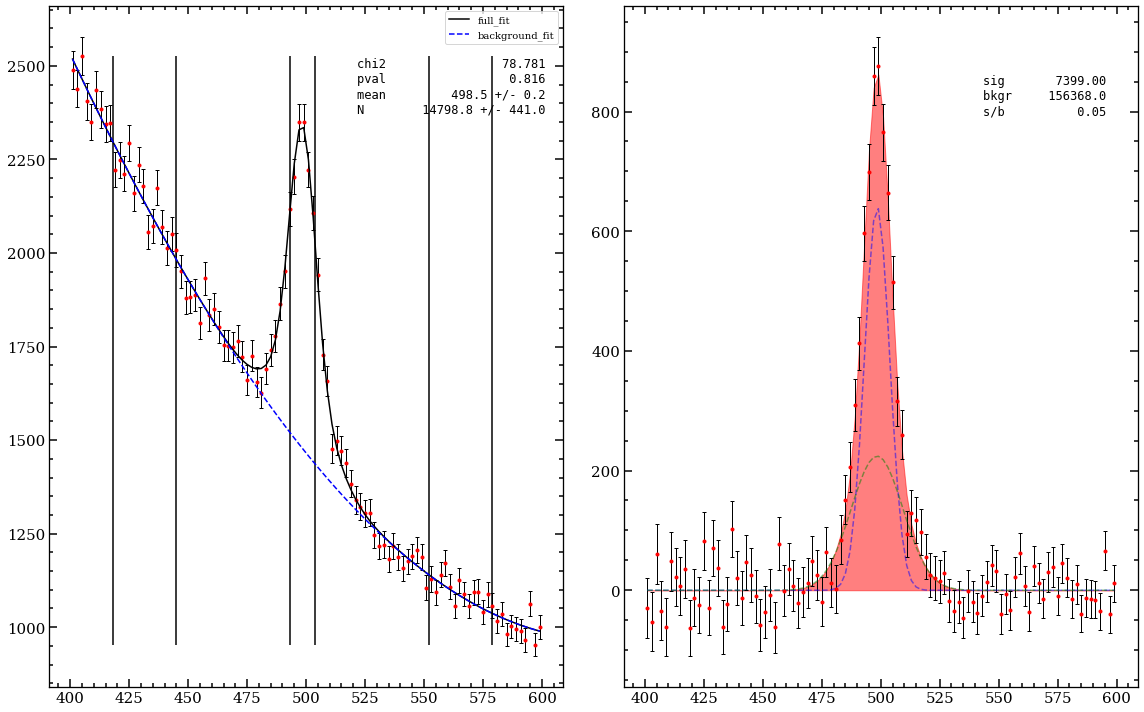

In [50]:
train_sets[0] = hm.assign_pseudolabels(train_sets[0])

In [51]:
classifiers = [xgb.XGBClassifier() for i in range(len(model_features))]
classifiers[0].fit(train_sets[0][model_features[0]],train_sets[0].y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [52]:
p0 = classifiers[0].predict_proba(train_sets[1][model_features[0]])[:,1]

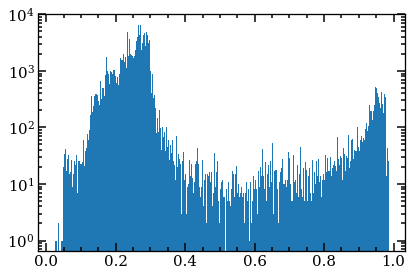

In [53]:
plt.hist(p0);
plt.yscale('log')

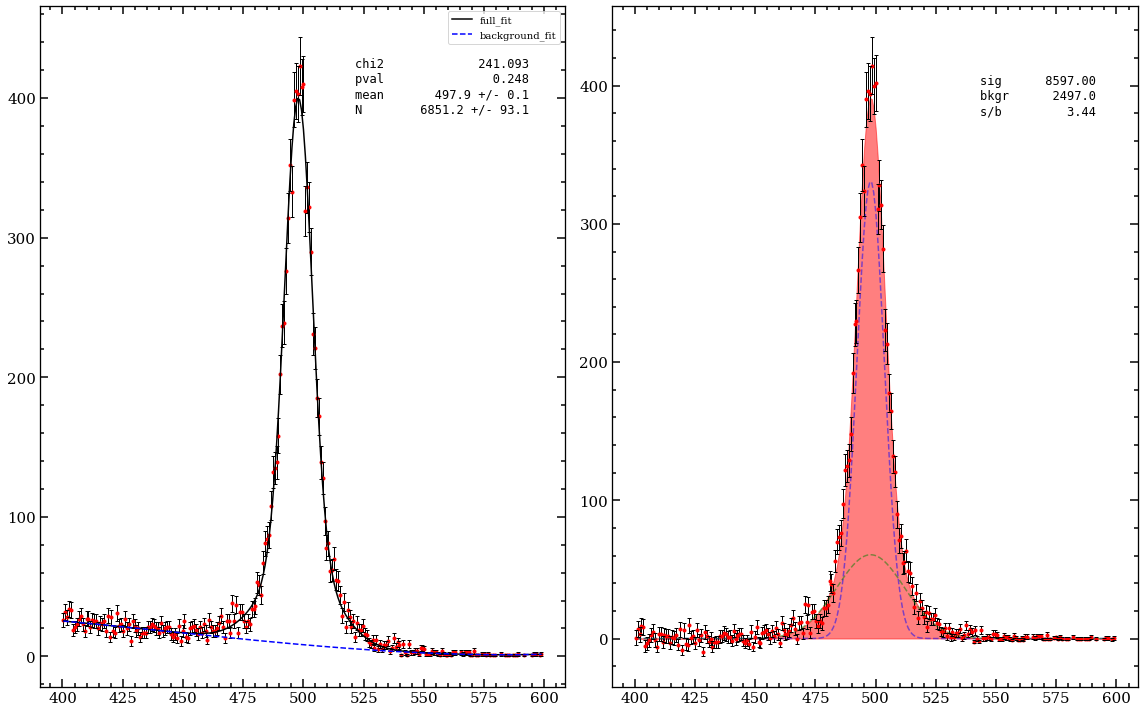

In [54]:
vals, binc, binw = hm.hist(train_sets[1].loc[p0 > 0.6].v0_ks_mass,bins=250)
mask = vals > 0
d = hm.fit_mass2(binc[mask],vals[mask],np.sqrt(vals[mask]))

In [69]:
sig = train_sets[1].loc[(p0 > 0.6)&(train_sets[1].v0_ks_mass >475)&(train_sets[1].v0_ks_mass < 525)]
bkgr = train_sets[1].loc[p0 < 0.5]
sig_len, bkgr_len = len(sig), len(bkgr)

train_sets[1] = pd.concat([sig,bkgr])
train_sets[1]['y'] = np.append(np.ones(sig_len),np.zeros(bkgr_len))

In [71]:
classifiers[1].fit(train_sets[1][model_features[1]],train_sets[1].y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [74]:
p1 = classifiers[1].predict_proba(test_data[model_features[1]])[:,1]

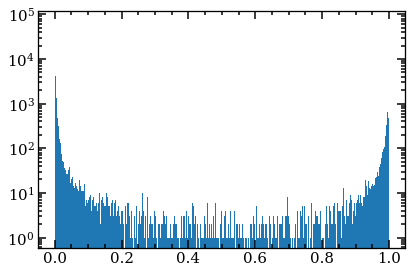

In [83]:
plt.hist(p1,bins=500);
plt.yscale('log')

In [84]:
help(hm.ROC_data)

Help on function ROC_data in module HomeMade:

ROC_data(mass, p, thresholds=20, eq_intervals=False, plot_fit=True, plot_ROC=True)



0
No values, skipping..
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
No background valid minimum found!
15
16
17
18
No background valid minimum found!


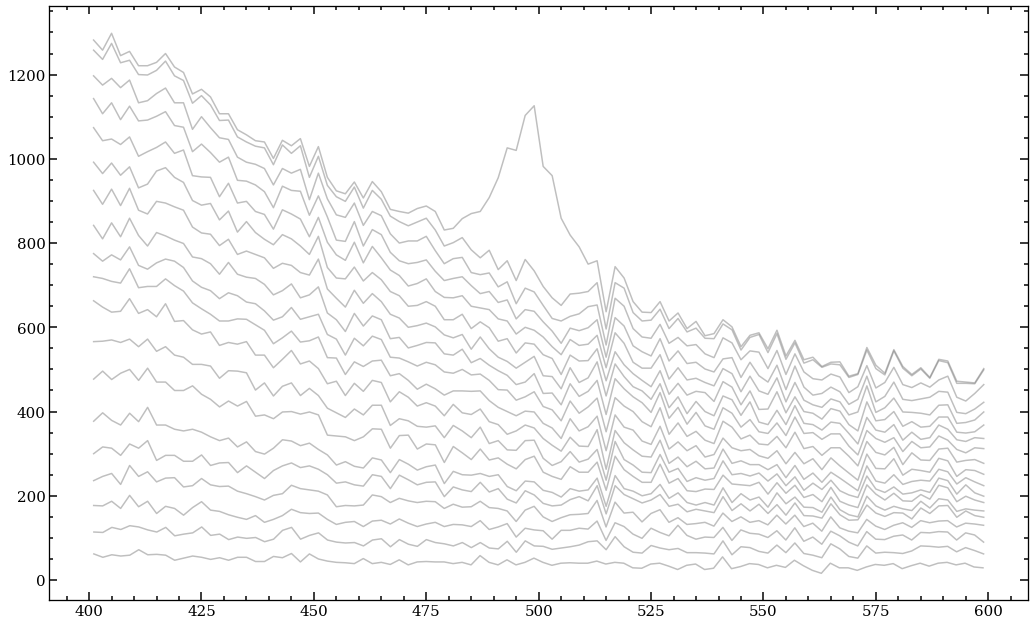

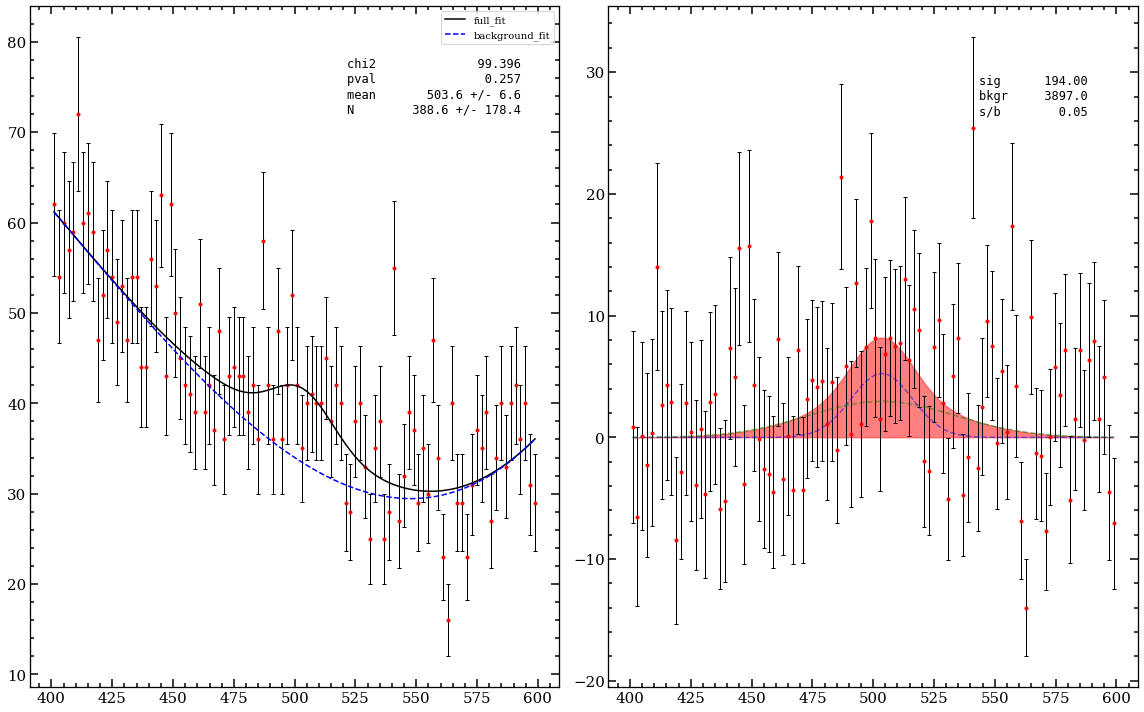

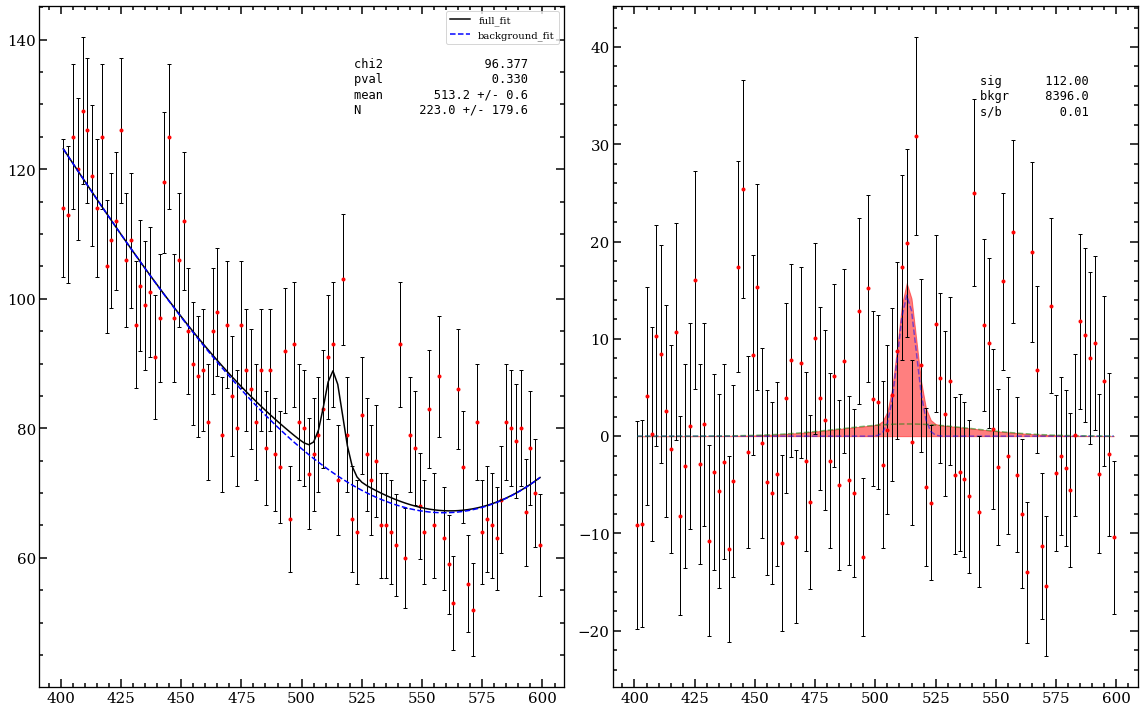

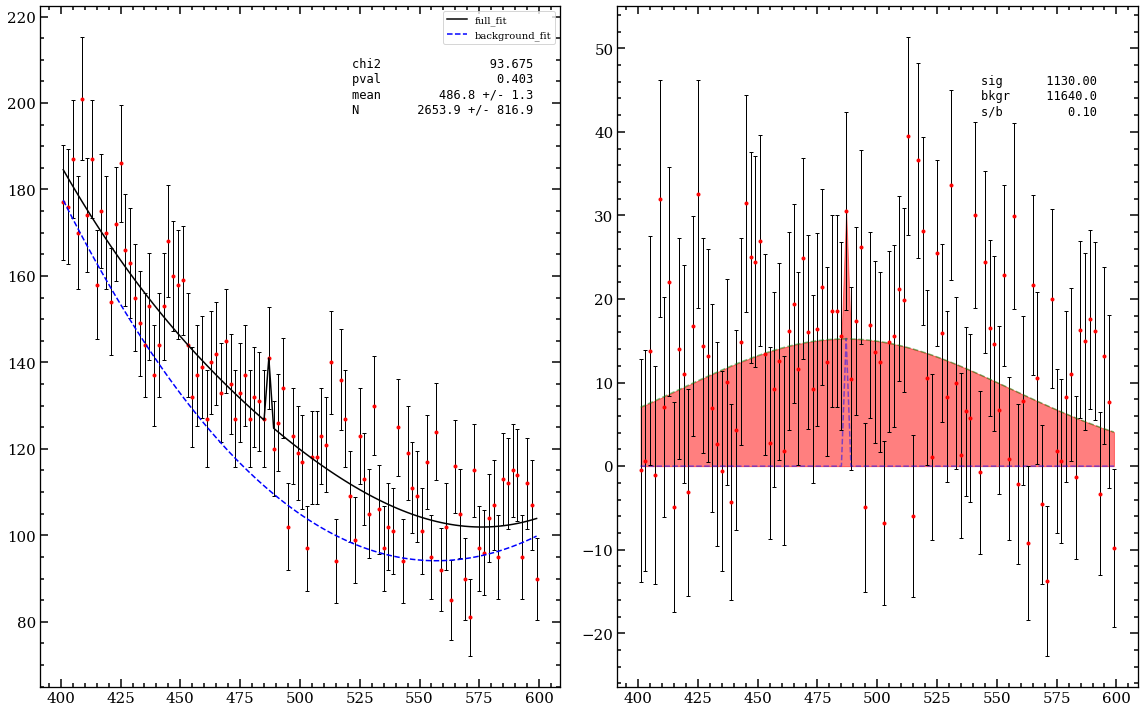

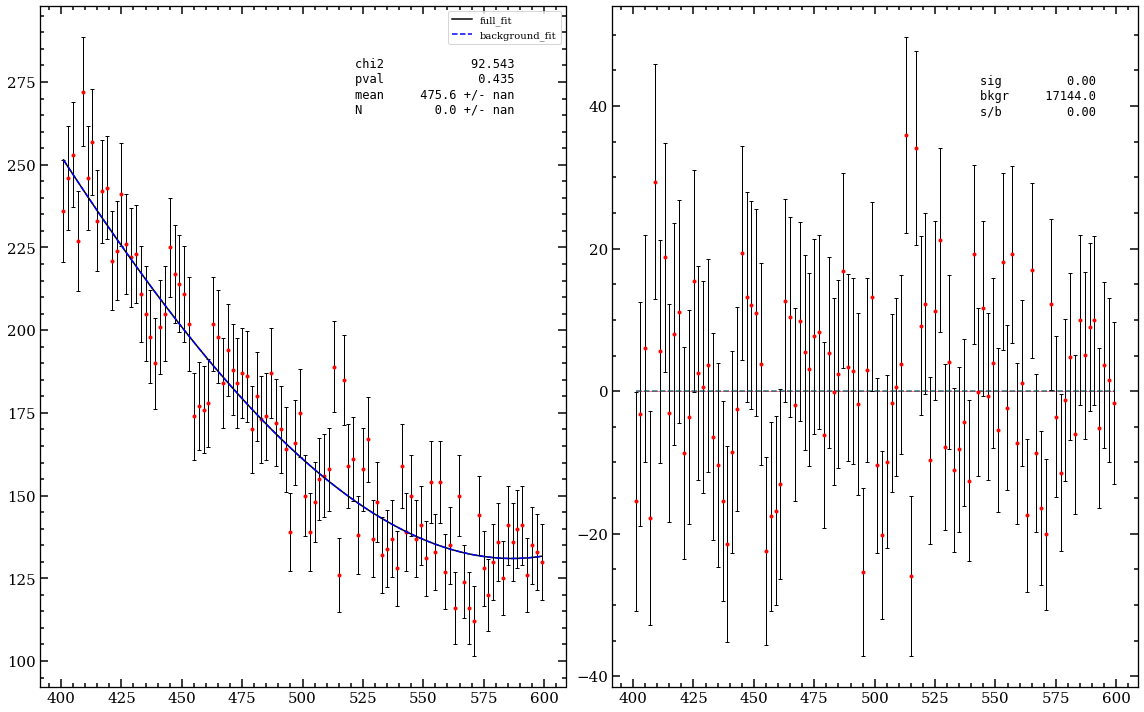

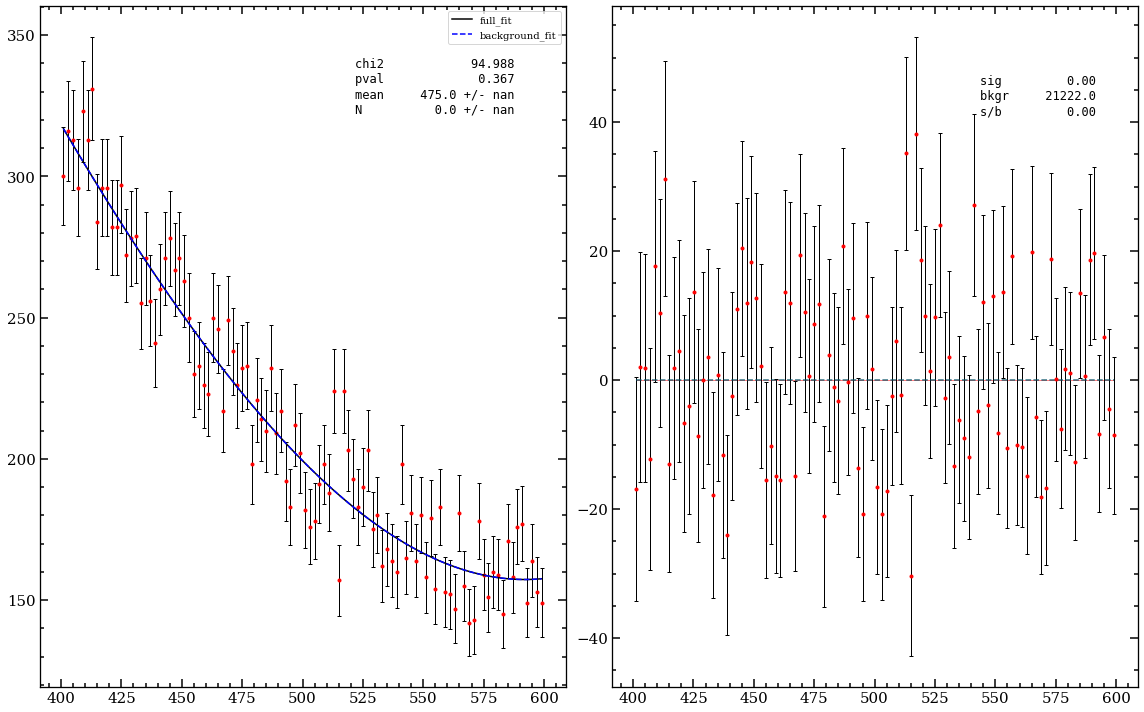

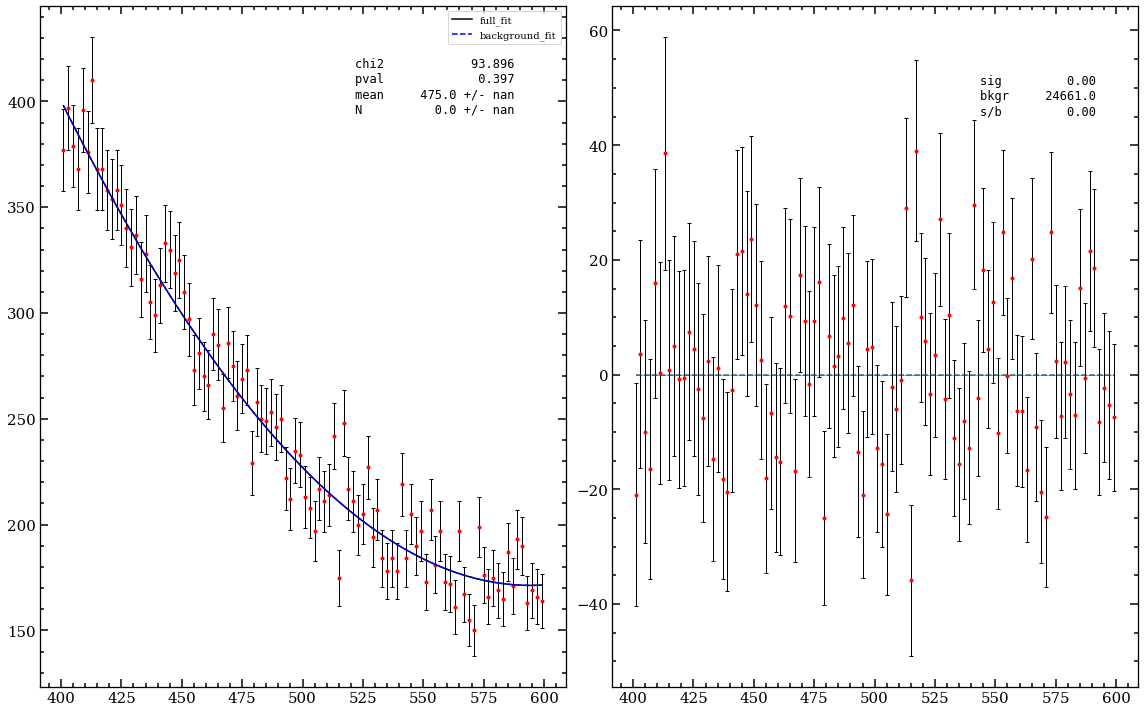

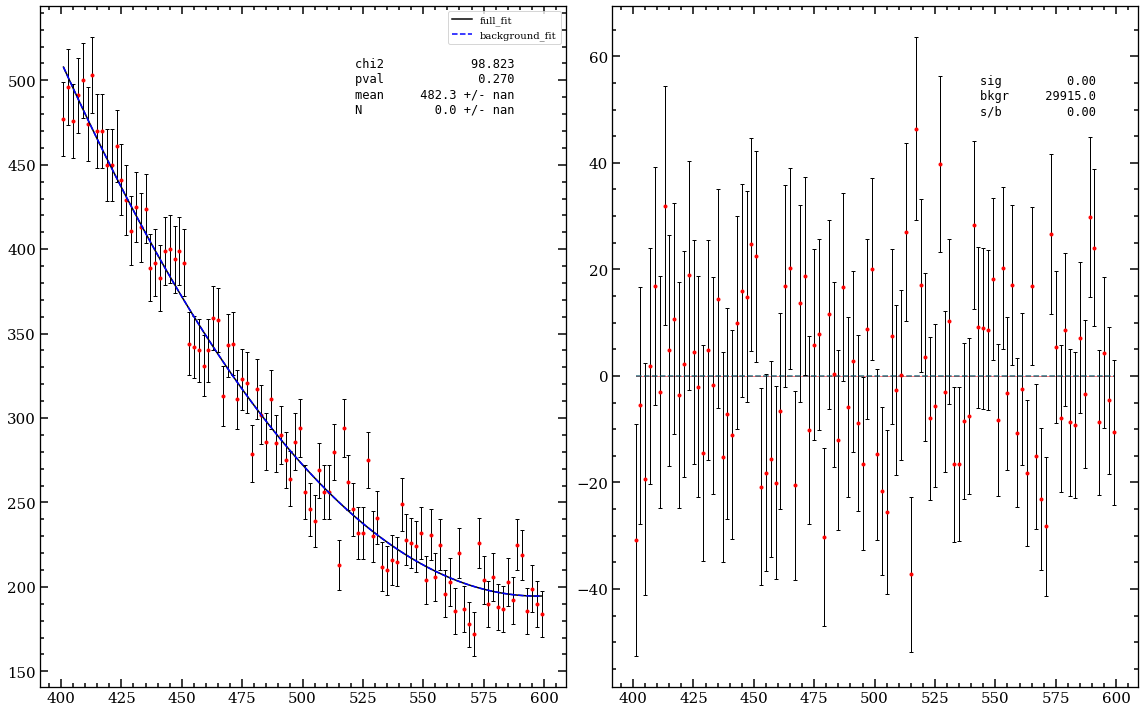

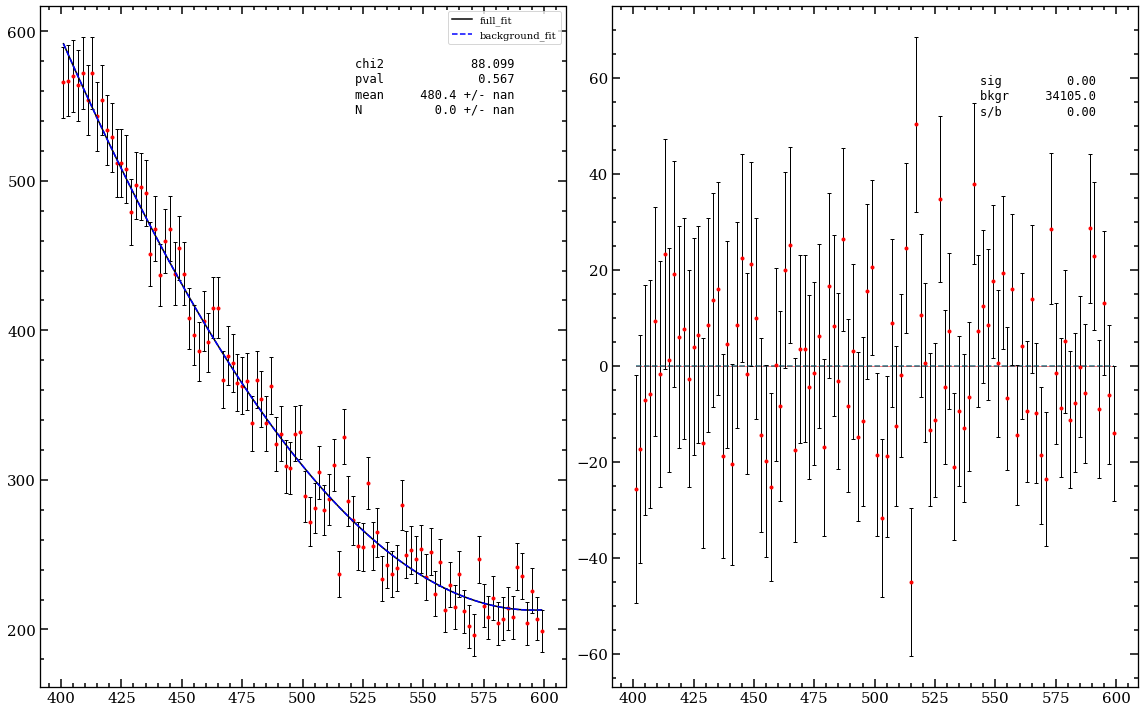

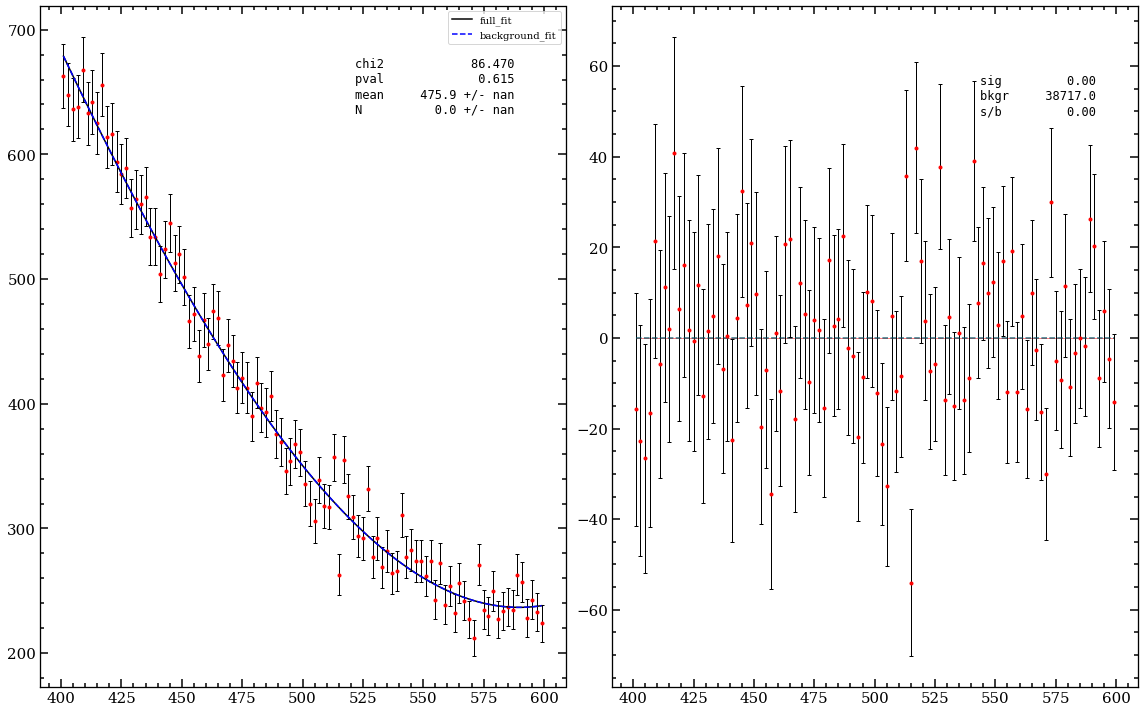

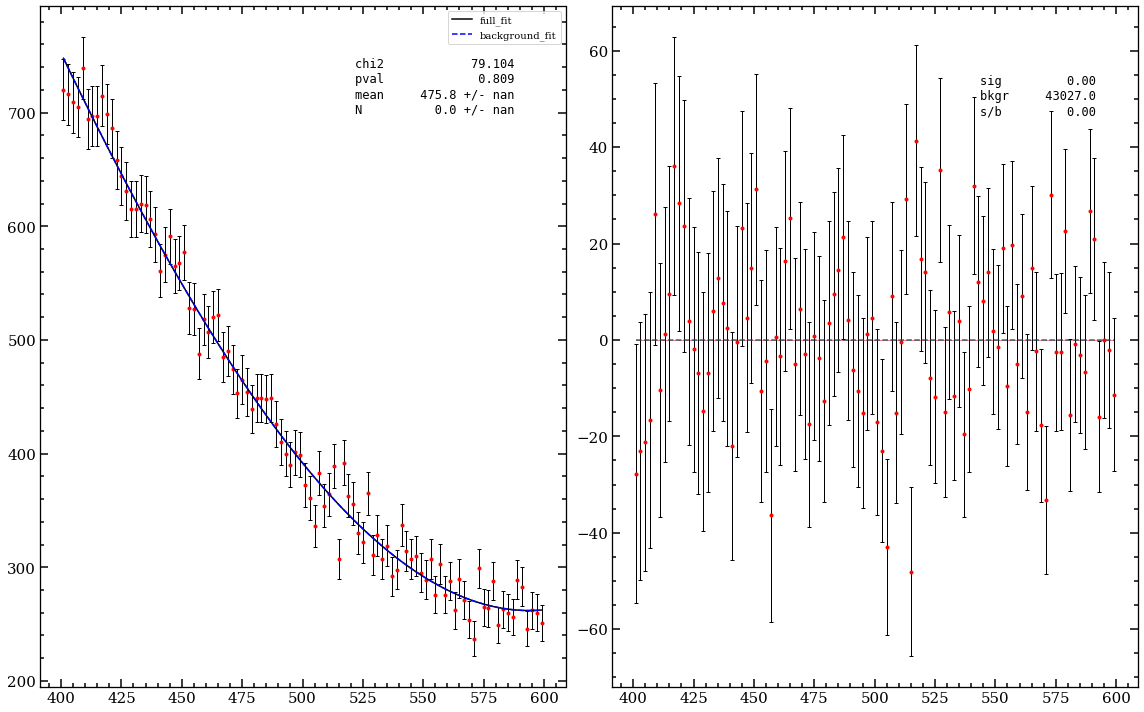

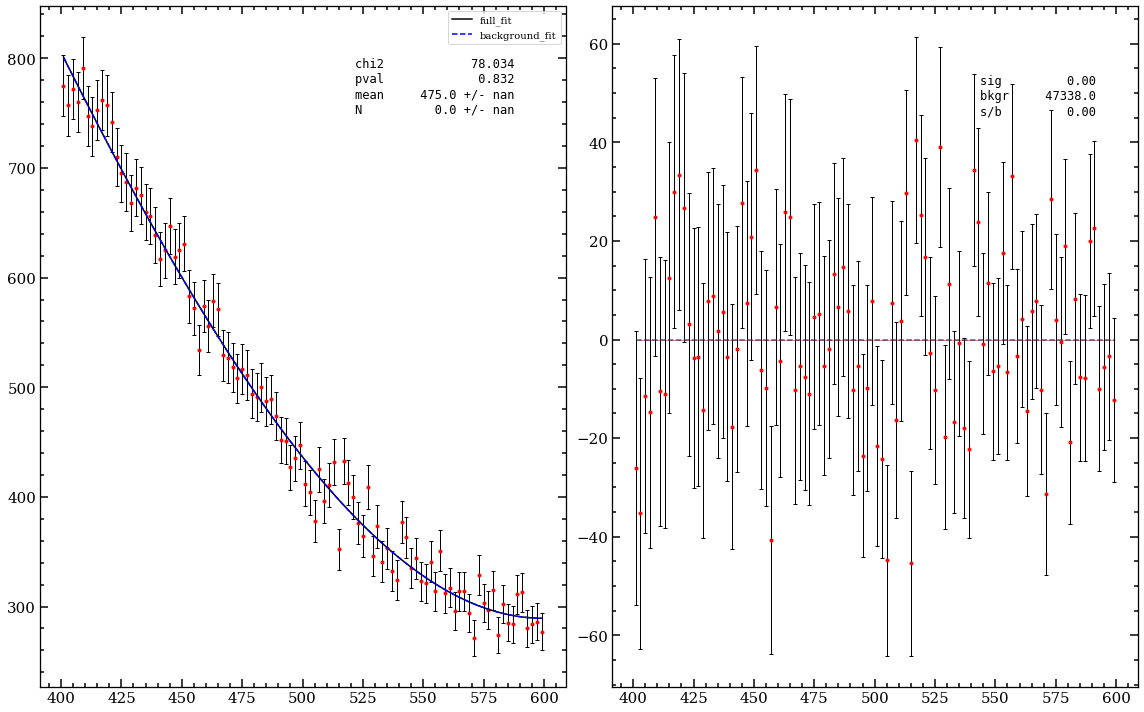

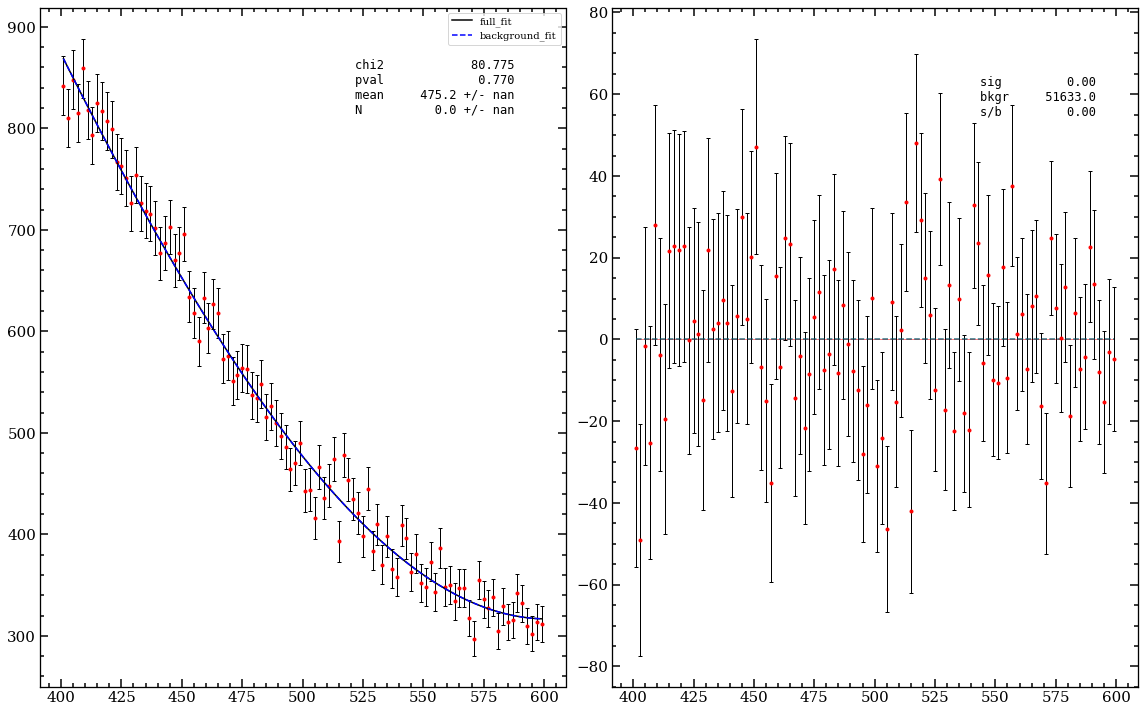

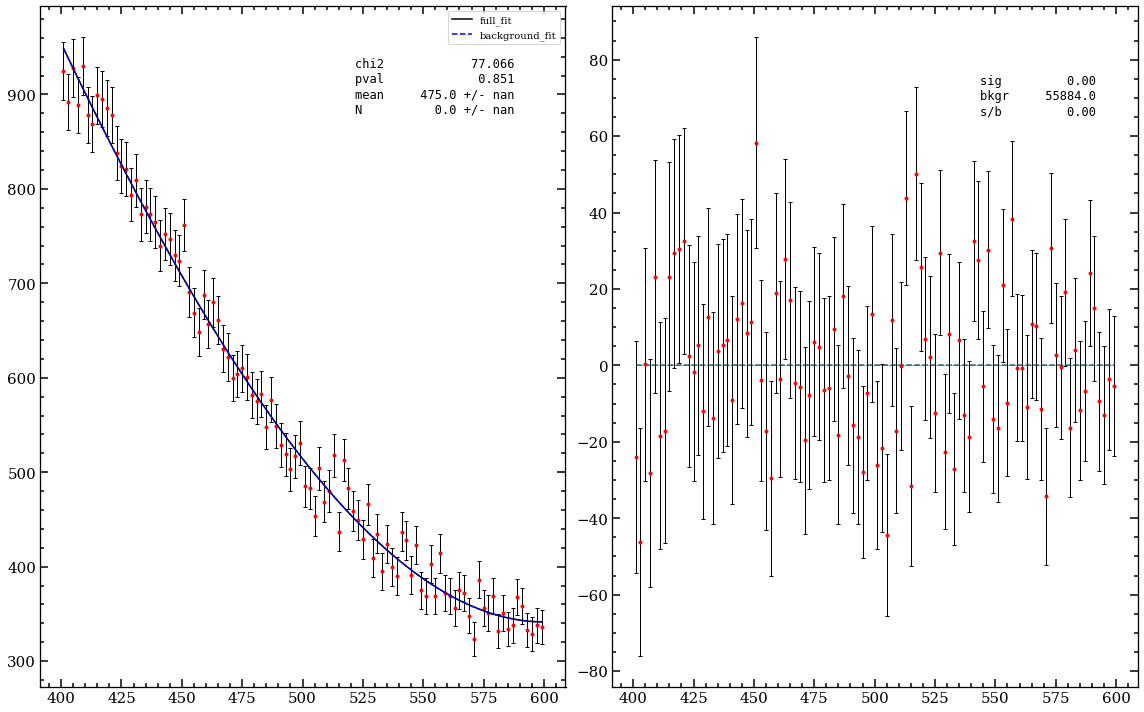

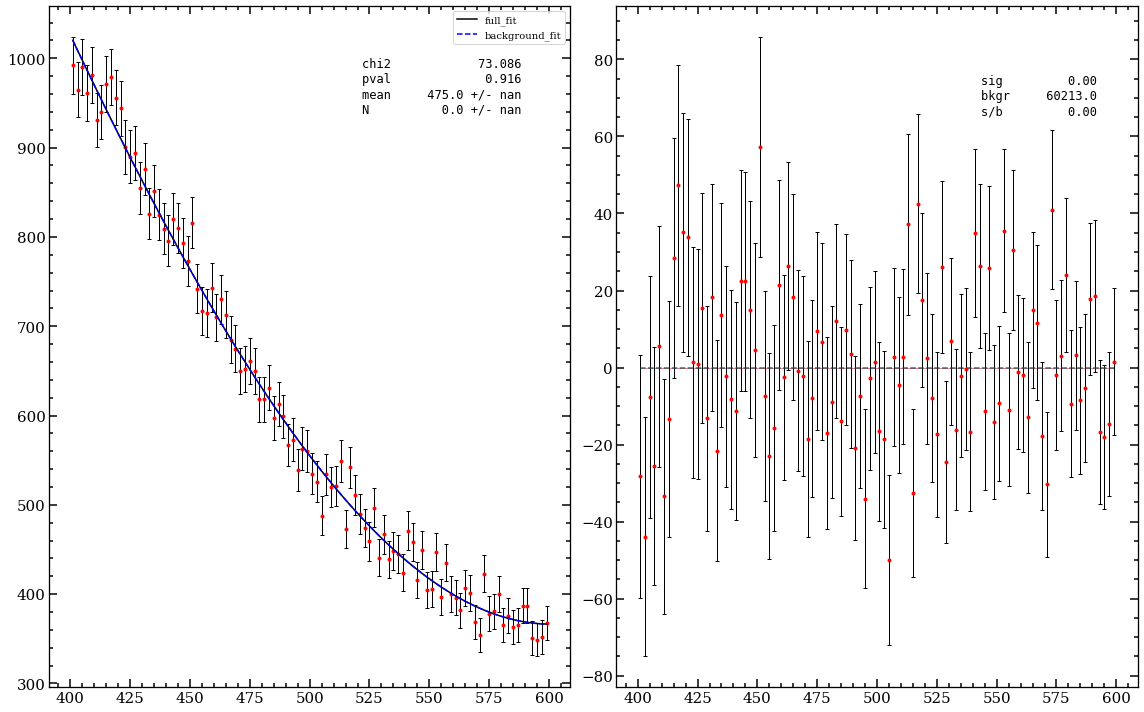

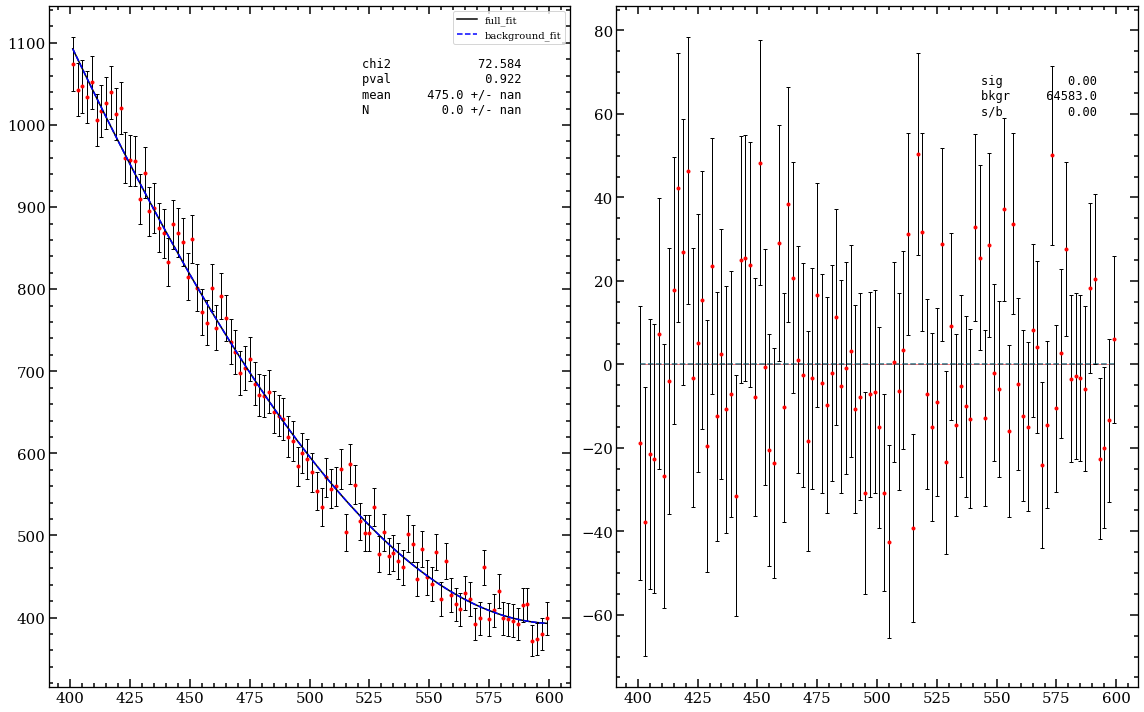

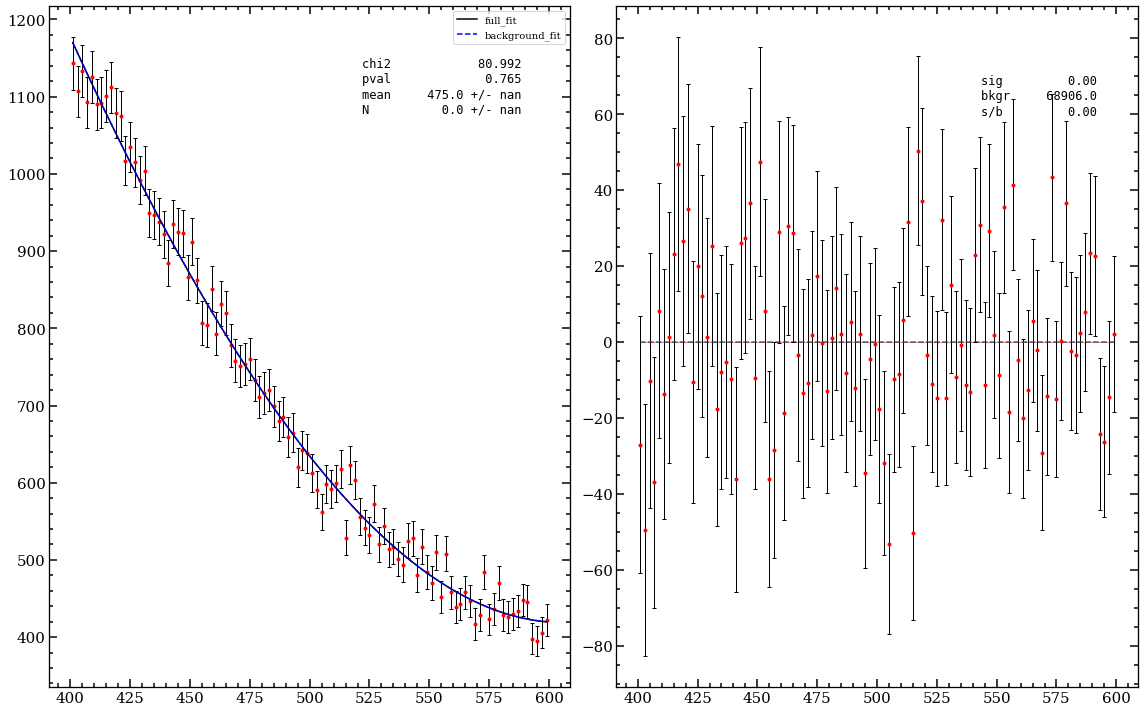

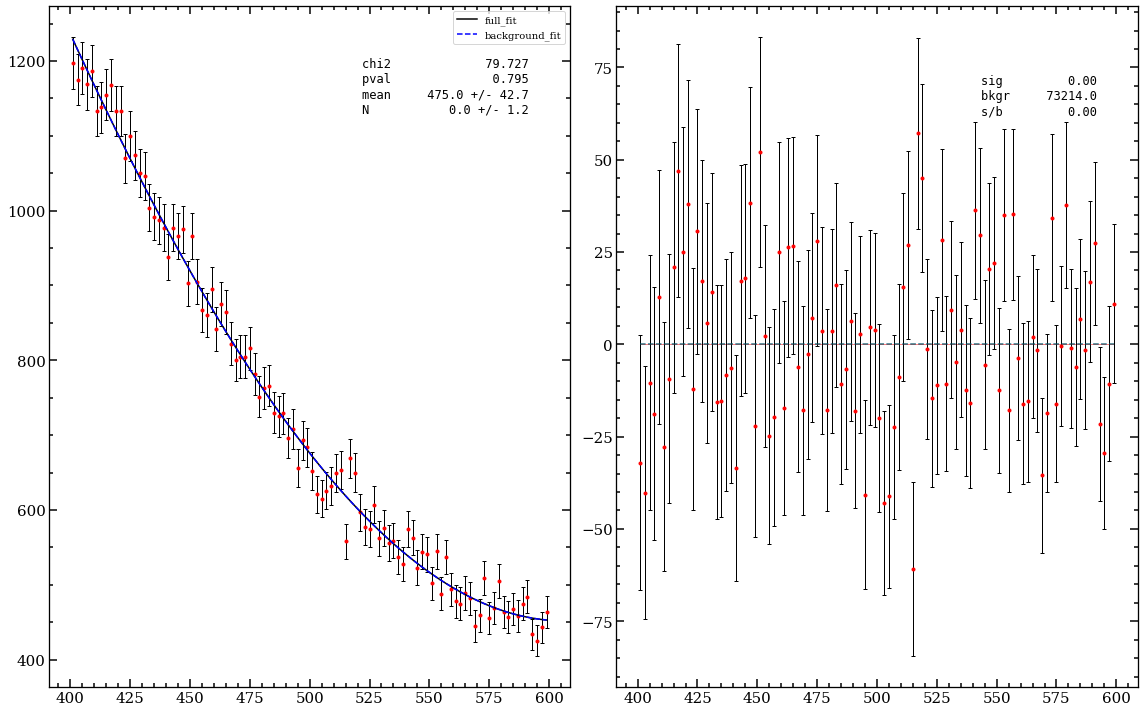

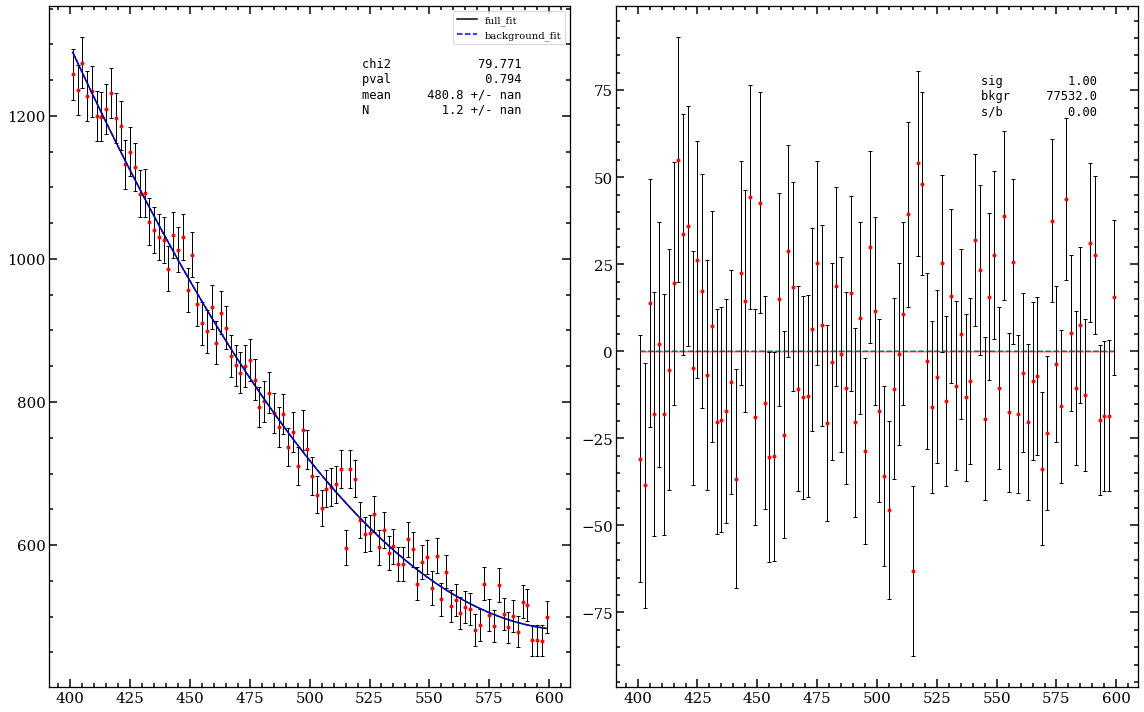

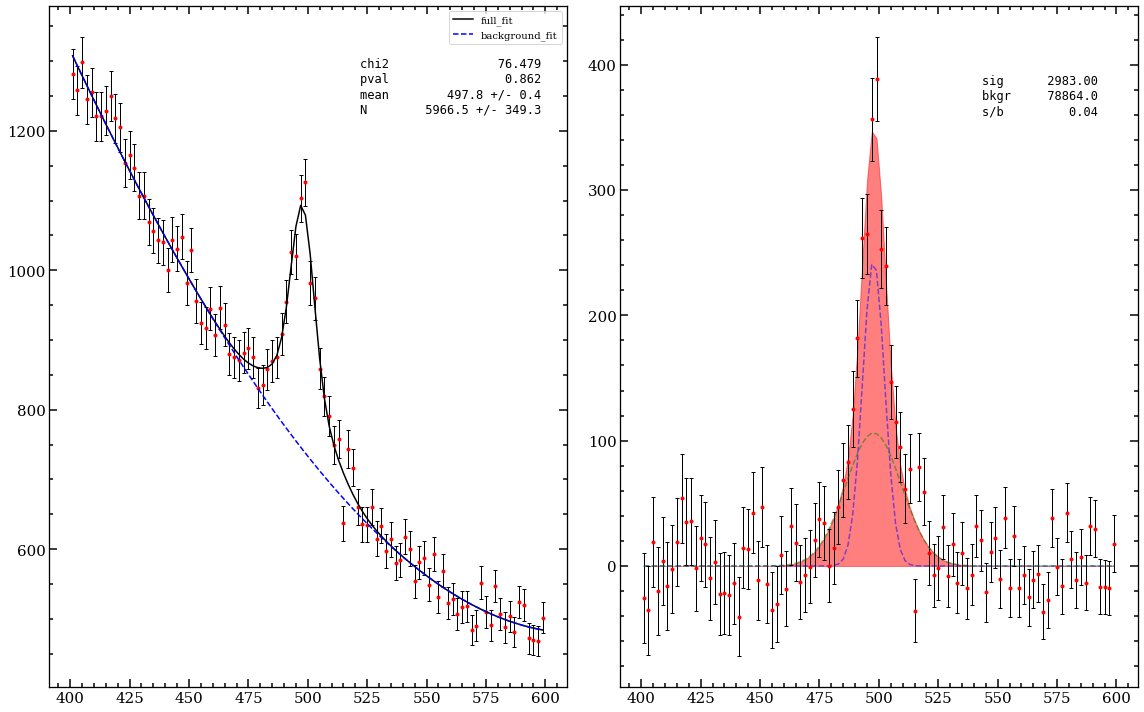

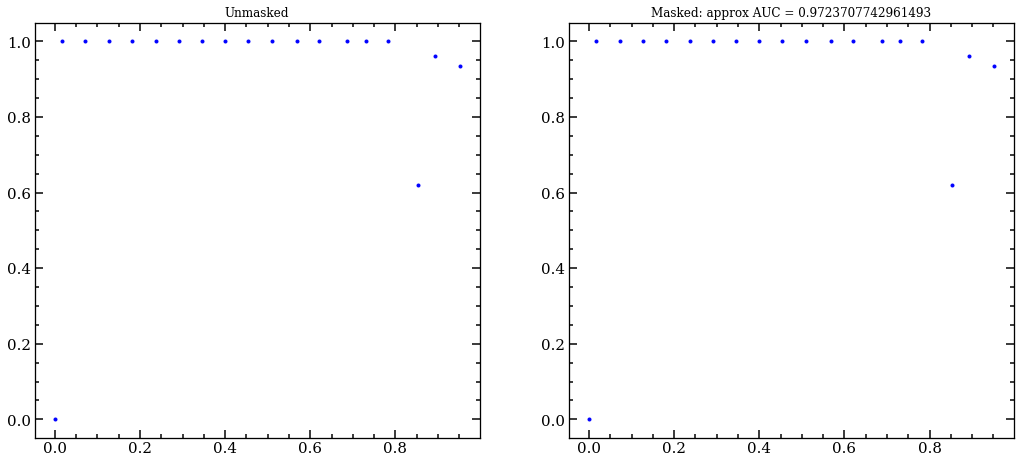

In [87]:
c = hm.ROC_data(test_data.v0_ks_mass, p1,thresholds = 20)